In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
import numpy as np
from PIL import Image
import thesis_rcparams

In [2]:
def add_circular_image(ax, img_path, xy, zoom=1.0, circle_zoom=1.0):
    """
    Add a circular cropped image at a specific point on the matplotlib axis
    
    Parameters:
        ax: matplotlib axis object
        img_path: path to the image file
        xy: tuple (x, y) for the position
        zoom: scaling factor for the image
        circle_zoom: controls the size of the circular crop (0-1)
    """
    # Load the image
    img = plt.imread(img_path)
    
    # Get the image dimensions
    height, width = img.shape[0], img.shape[1]
    
    # Create a circular mask
    center = (width // 2, height // 2)
    radius = min(width, height) // 2 * circle_zoom
    
    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    
    mask = dist_from_center <= radius
    
    # Apply the mask to create a circular image
    if img.shape[-1] == 4:  # Image with an alpha channel
        img_circular = img.copy()
        img_circular[~mask] = [0, 0, 0, 0]  # Transparent
    else:  # RGB image
        img_circular = np.zeros((height, width, 4), dtype=np.uint8)
        if len(img.shape) == 3:
            img_circular[mask, :3] = img[mask]
        else:
            img_circular[mask, :3] = np.stack([img[mask]]*3, axis=-1)
        img_circular[mask, 3] = 255  # Full opacity for the circle
    
    # Create an OffsetImage
    imagebox = mpl.offsetbox.OffsetImage(img_circular, zoom=zoom)
    imagebox.image.axes = ax
    
    # Create an AnnotationBbox
    ab = mpl.offsetbox.AnnotationBbox(
        imagebox, xy, 
        xycoords='data', 
        boxcoords="offset points",
        pad=0.0, 
        frameon=False,
        clip_on=True,  # Add this to clip the image to the axes
    )
    
    # Add the annotation to the axis
    ax.add_artist(ab)
    
    return ab

In [3]:
def add_thresholded_negative_circular_image(ax, img_path, xy, zoom=1.0, circle_zoom=1.0, threshold=0.7):
    """
    Add a negative image with white background thresholding as a circular crop
    
    Parameters:
        ax: matplotlib axis object
        img_path: path to the image file
        xy: tuple (x, y) for the position
        zoom: scaling factor for the image
        circle_zoom: controls the size of the circular crop (0-1)
        threshold: brightness threshold (0-1), pixels above this become pure white
    """
    # Load the image
    img = plt.imread(img_path)
    
    # Convert to float if not already
    if img.dtype == np.uint8:
        img = img.astype(float) / 255.0
    
    # Create negative image by inverting colors
    if len(img.shape) == 3 and img.shape[2] >= 3:
        img_negative = img.copy()
        img_negative[..., :3] = 1.0 - img_negative[..., :3]
    else:
        img_negative = 1.0 - img
        
    # Calculate brightness of the negative image
    if len(img_negative.shape) == 3 and img_negative.shape[2] >= 3:
        brightness = np.mean(img_negative[..., :3], axis=2)
    else:
        brightness = img_negative
    
    # Apply threshold - set pixels above threshold to white
    white_mask = brightness > threshold
    if len(img_negative.shape) == 3 and img_negative.shape[2] >= 3:
        img_negative[white_mask, :3] = 1.0  # Set to white
    else:
        img_negative[white_mask] = 1.0  # Set to white
    
    # Get the image dimensions
    height, width = img.shape[0], img.shape[1]
    
    # Create a circular mask
    center = (width // 2, height // 2)
    radius = min(width, height) // 2 * circle_zoom
    
    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    
    mask = dist_from_center <= radius
    
    # Apply the mask to create a circular image
    if img.shape[-1] == 4:  # Image with an alpha channel
        img_circular = img_negative.copy()
        img_circular[~mask] = [0, 0, 0, 0]  # Transparent
    else:  # RGB image
        img_circular = np.zeros((height, width, 4), dtype=np.float32)
        if len(img_negative.shape) == 3:
            img_circular[mask, :3] = img_negative[mask, :3]
        else:
            img_circular[mask, :3] = np.stack([img_negative[mask]]*3, axis=-1)
        img_circular[mask, 3] = 1.0  # Full opacity for the circle
    
    # Create an OffsetImage
    imagebox = mpl.offsetbox.OffsetImage(img_circular, zoom=zoom)
    imagebox.image.axes = ax
    
    # Create an AnnotationBbox
    ab = mpl.offsetbox.AnnotationBbox(
        imagebox, xy, 
        xycoords='data', 
        boxcoords="offset points",
        pad=0.0, 
        frameon=False,
        clip_on=True  # Clip the image to the axes
    )
    
    # Add the annotation to the axis
    ax.add_artist(ab,)
    
    return ab

In [4]:
primary =   np.array([-0.5,.25])
secondary = np.array([.5,.5])
tertiary =  np.array([0.5,.9])


D12 = secondary - primary
D13 = tertiary - primary
D23 = tertiary - secondary

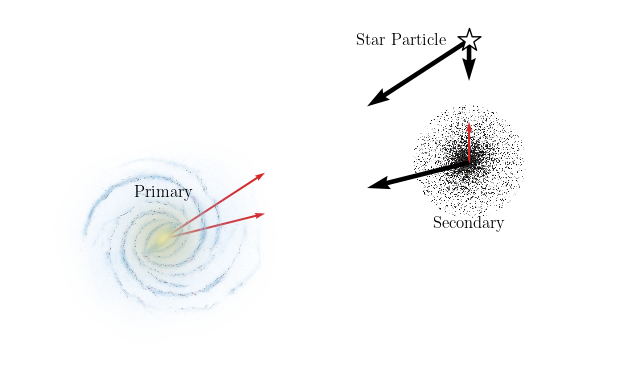

In [5]:
fig,axis = plt.subplots(1, 1, figsize=(8.25-2, 4))
axis.set_axis_off()




# axis.scatter(primary[0], primary[1], s=1000, c='black', alpha=1, label='Primary',zorder=10)
# axis.scatter(secondary[0], secondary[1], s=500, c='black', alpha=1, label='Secondary',zorder=100)
axis.scatter(tertiary[0], tertiary[1], s=300, alpha=1,marker="*", label='Tertiary',zorder=100,edgecolor="black",facecolor="white")

add_circular_image(axis, 'Milky_Way_Galaxy_transparent_background.png', primary, zoom=1/5, circle_zoom=0.95)

add_thresholded_negative_circular_image(axis, 'Globular_Cluster_M2.jpg', secondary, zoom=1/15, circle_zoom=0.95,threshold=0.4,)

axis.text(primary[0], primary[1]+0.15, 'Primary', fontsize=12, ha='center', va='center', color='black')  
axis.text(secondary[0], secondary[1]-0.20, 'Secondary', fontsize=12, ha='center', va='center', color='black')  
axis.text(tertiary[0] - 0.075, tertiary[1], 'Star Particle', fontsize=12, ha='right', va='center', color='black')  


axis.quiver(primary[0], primary[1], D12[0], D12[1], angles='xy', scale_units='xy', scale=3, color='tab:red',zorder=1,width=1/300)
axis.quiver(primary[0], primary[1], D13[0], D13[1], angles='xy', scale_units='xy', scale=3, color='tab:red',zorder=1,width=1/300)


axis.quiver(secondary[0], secondary[1], D23[0], D23[1], angles='xy', scale_units='xy', scale=3, color='tab:red',zorder=10,width=1/300)
axis.quiver(secondary[0], secondary[1], -D12[0], -D12[1], angles='xy', scale_units='xy', scale=3, color='black',zorder=10)

axis.quiver(tertiary[0], tertiary[1], -D23[0], -D23[1], angles='xy', scale_units='xy', scale=3, color='black',zorder=10,)
axis.quiver(tertiary[0], tertiary[1], -D13[0], -D13[1], angles='xy', scale_units='xy', scale=3, color='black',zorder=10,)


axis.set_xlim(-1., 1.)
axis.set_ylim(0, 1.0)
axis.set_aspect('equal')
fig.tight_layout(pad=0)
fig.savefig("../images/restricted_three_body_set_up.png", dpi=300, pad_inches=0.0)